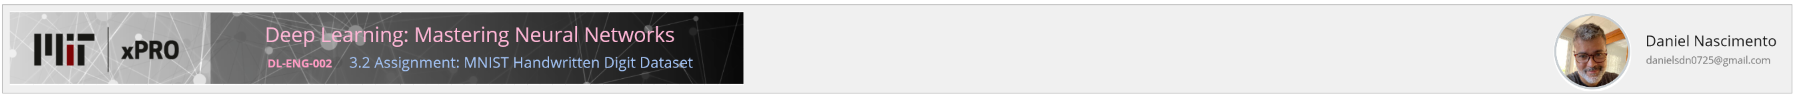

# 3.2 Assignment: MNIST Handwritten Digit Dataset DanielNascimento

## 1 - Importating thew raw dataset and Dataloader creation

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import time
import os
import copy
from torch.utils.data import TensorDataset, DataLoader

from torch.optim import SGD
import torch.optim as optim
import torch.nn.functional as F
from torch import optim

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [4]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 64
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### 40 samples of mnist_train

In [5]:
train_x = mnist_train.dataset.data
train_y = mnist_train.dataset.targets

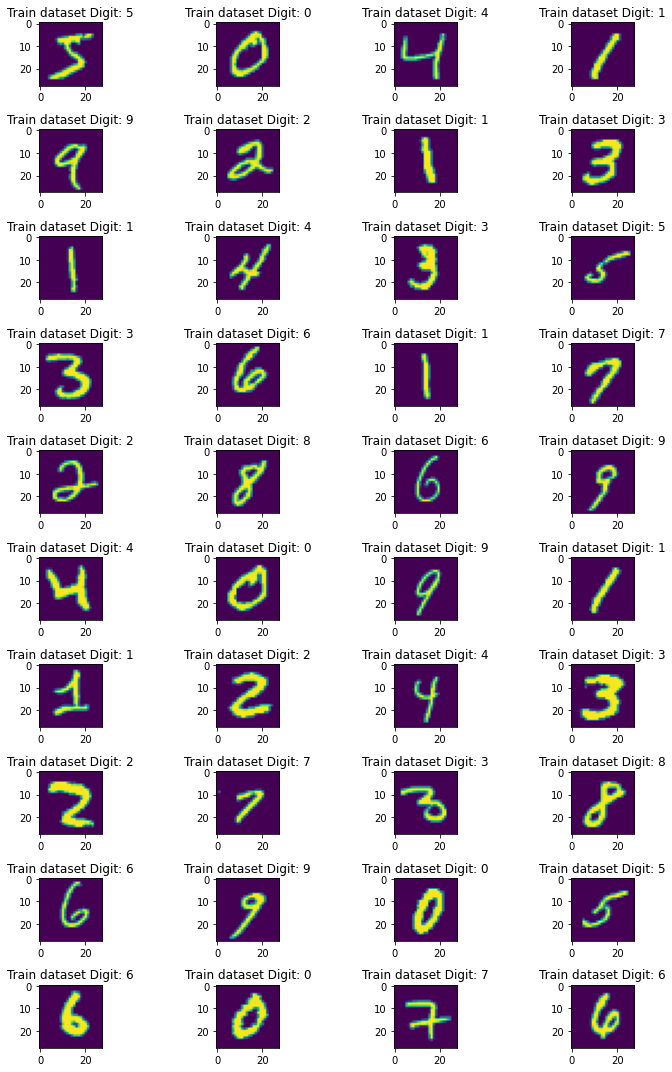

In [6]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(train_x[i])
    plt.title(f'Train dataset Digit: {train_y[i]}')
fig.tight_layout()
plt.show()

### 40 samples of mnist_test

In [7]:
test_x = mnist_test.data
test_y = mnist_test.targets

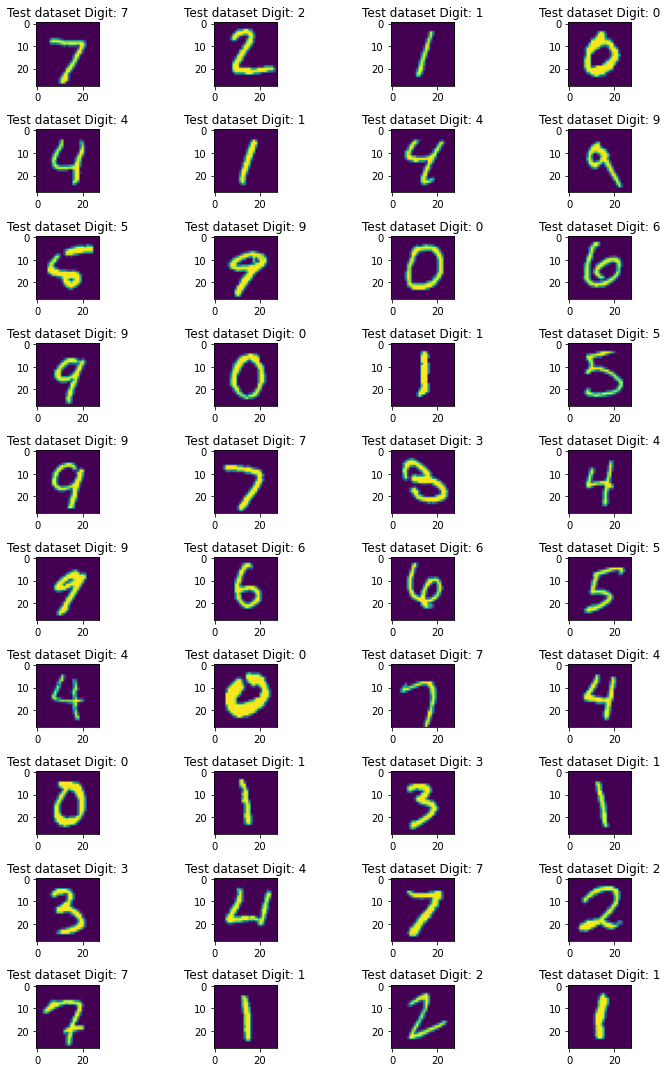

In [8]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(test_x[i])
    plt.title(f'Test dataset Digit: {test_y[i]}')
fig.tight_layout()
plt.show()

## 2 - Model - the network: Hyperparameters and Definition


In [12]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

Let’s break down the layers in the handwrite MNIST model. The images has a size of 28x28 - so we need to flatten them. (self.flatten = nn.Flatten())

The first nn.linear layer, do it including: "nn.Linear(28*28, 512)"

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [14]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [15]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1])


### Breaking down the mdel layers

The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

1 - We will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [16]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


2 - We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

In [17]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


3 - The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

In [18]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


4 - Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

In [19]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.5757,  0.2957, -0.0710, -0.2549,  0.2291,  0.3708, -0.3132, -0.5283,
         -0.0757,  0.4295,  0.2513, -0.2231,  0.1345, -0.2644,  0.1118, -0.0656,
         -0.0029,  0.2779, -0.2161,  0.4653],
        [ 0.6788,  0.3909,  0.1160,  0.3475,  0.0679,  0.2357, -0.1486, -0.4766,
         -0.1814,  0.2006,  0.3628, -0.0816,  0.0640, -0.3007, -0.4291, -0.2197,
          0.2747, -0.0699, -0.2447,  0.1839],
        [ 0.6136,  0.3567, -0.0281,  0.1916,  0.1208,  0.2856, -0.0640, -0.6661,
         -0.0656,  0.0388, -0.2834,  0.0298, -0.0339,  0.1148,  0.0830,  0.0080,
          0.1457,  0.0034, -0.0579,  0.2920]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.5757, 0.2957, 0.0000, 0.0000, 0.2291, 0.3708, 0.0000, 0.0000, 0.0000,
         0.4295, 0.2513, 0.0000, 0.1345, 0.0000, 0.1118, 0.0000, 0.0000, 0.2779,
         0.0000, 0.4653],
        [0.6788, 0.3909, 0.1160, 0.3475, 0.0679, 0.2357, 0.0000, 0.0000, 0.0000,
         0.2006, 0.3628, 0.0000, 0.0640, 0.0000, 0.00

5 - nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like seq_modules.

In [20]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(1,28,28)
logits = seq_modules(input_image)

6 - The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1

In [21]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

7 - Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s parameters() or named_parameters() methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.

In [22]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0281,  0.0161, -0.0173,  ...,  0.0054,  0.0010,  0.0096],
        [-0.0086,  0.0100,  0.0216,  ...,  0.0103,  0.0188,  0.0087]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0069,  0.0211], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0211, -0.0030, -0.0022,  ..., -0.0191,  0.0186, -0.0127],
        [ 0.0255, -0.0143,  0.0356,  ..., -0.0387, -0.0370,  0.0055]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

## 3 - Training the Model



In [23]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves



In [25]:
# loss and optimizer
learning_rate = 0.001
num_epochs = 10

model = NeuralNetwork()

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_model(model.to(device), dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.3294 Acc: 0.8984
val   Loss: 0.2020 Acc: 0.9356
test  Loss: 0.1996 Acc: 0.9356

Epoch 2/10
----------
train Loss: 0.1495 Acc: 0.9534
val   Loss: 0.1457 Acc: 0.9533
test  Loss: 0.1471 Acc: 0.9509

Epoch 3/10
----------
train Loss: 0.1110 Acc: 0.9655
val   Loss: 0.1465 Acc: 0.9531
test  Loss: 0.1439 Acc: 0.9526

Epoch 4/10
----------
train Loss: 0.0848 Acc: 0.9732
val   Loss: 0.1176 Acc: 0.9633
test  Loss: 0.1175 Acc: 0.9635

Epoch 5/10
----------
train Loss: 0.0689 Acc: 0.9775
val   Loss: 0.1104 Acc: 0.9677
test  Loss: 0.1069 Acc: 0.9667

Epoch 6/10
----------
train Loss: 0.0533 Acc: 0.9824
val   Loss: 0.1140 Acc: 0.9690
test  Loss: 0.1118 Acc: 0.9669

Epoch 7/10
----------
train Loss: 0.0404 Acc: 0.9862
val   Loss: 0.1248 Acc: 0.9691
test  Loss: 0.1190 Acc: 0.9668

Epoch 8/10
----------
train Loss: 0.0356 Acc: 0.9880
val   Loss: 0.1106 Acc: 0.9713
test  Loss: 0.1180 Acc: 0.9683

Epoch 9/10
----------
train Loss: 0.0292 Acc: 0.9902
val   Loss: 0.1448

In [28]:
torch.save(model.state_dict(), "model.pth")
print(f"\nSaved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth


Once our model has finished training we can see that just by including one set of Convolutional layers we have improved our accuracy compared to our previous 1D MLP. This is a great improvement for such a simple CNN implementation and by adding more convolutional layers and techniques the performance can be improved even further.

## 4 - Visualizing Training Curves and Results

Here we have included functions for examining the training curves and confusion matrix. Notice how the confusion matrix contains less missclassified entries than before.

In [ ]:
model.load_state_dict(torch.load("model.pth", map_location=torch.device(device)))

In [29]:
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


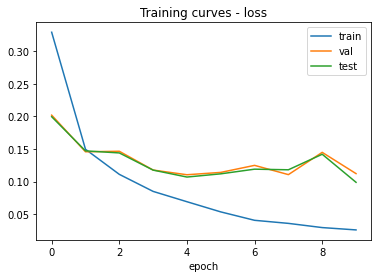

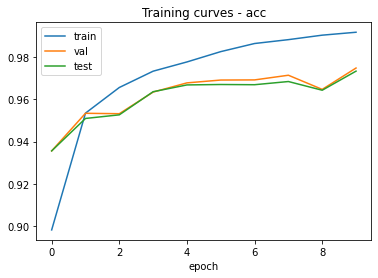

In [30]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

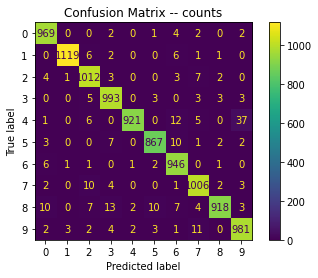

In [31]:
res = plot_cm(model, device, dataloaders, phase='test')